In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from reader import parse
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# парсинг данных
df_global = parse()
# фильтрация до 2020 года
df_under_2020 = df_global.loc[:'2019-12-01']  # delete data for 2020
# добавление фичи
df_under_2020['Time'] = np.arange(len(df_under_2020.index))

In [5]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(11, 4))
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor='0.25',
    markerfacecolor='0.25',
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

Text(0.5, 1.0, 'Time Plot of Signal')

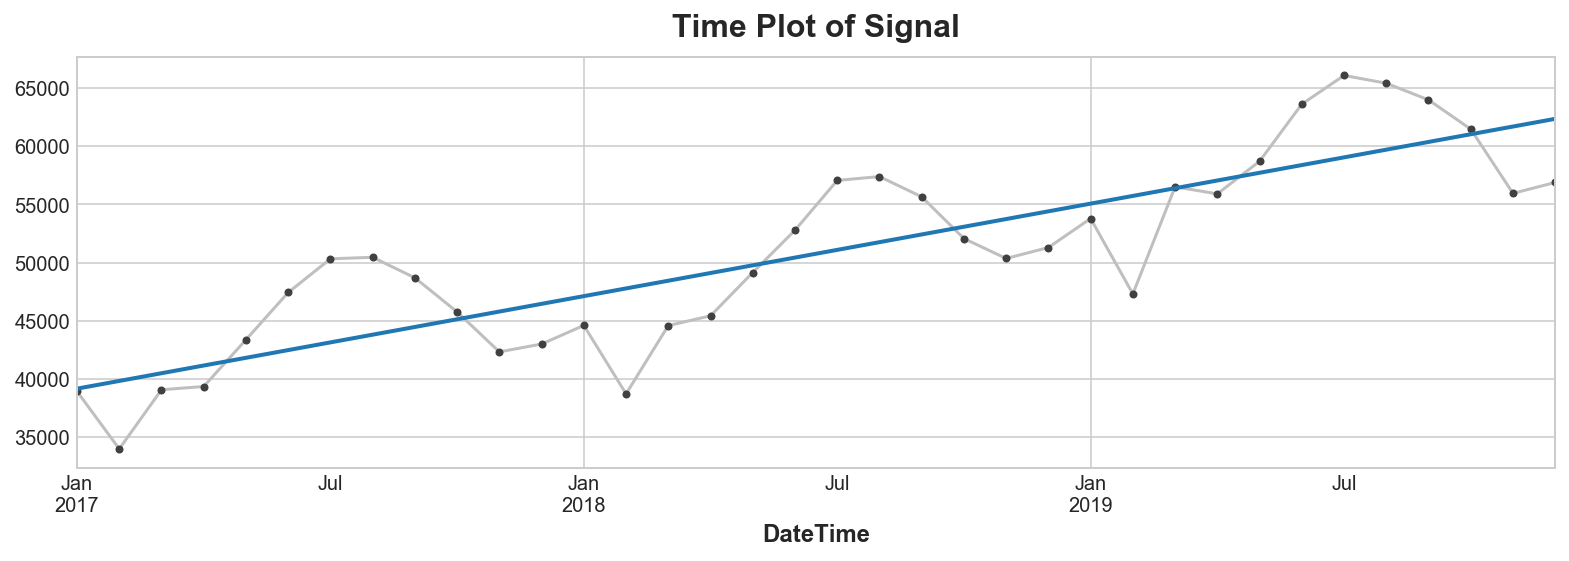

In [6]:
# Training data
X = df_under_2020.loc[:, ['Time']]
y = df_under_2020.loc[:, 'Signal']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=2)
ax.set_title('Time Plot of Signal')

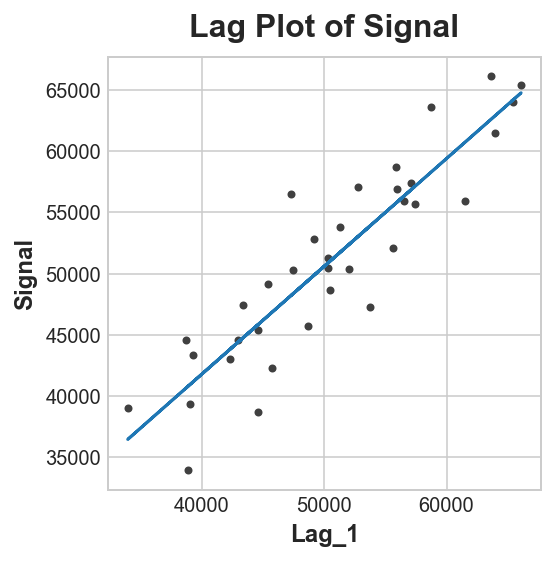

In [7]:
# добавление новой фичи
df_under_2020.loc[:, 'Lag_1'] = df_under_2020['Signal'].shift(1)

X = df_under_2020.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df_under_2020.loc[:, 'Signal']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Signal')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Signal');

In [9]:
# train-test split
def split_train_test_by_month(df, num_m=4):
    y = df['Signal']
    y_train = y[:-num_m]
    y_test = y[-num_m:]

    xdf = df.drop('Signal', inplace=False, axis=1)
    x_train = xdf[:-num_m]
    x_test = xdf[-num_m:]

    return x_train, y_train, x_test, y_test

In [74]:
# количество месяцев для предсказания
NUM_M = 4

df = df_under_2020.dropna()
df['Signal'] = np.round(df['Signal'], 2)

x_train, y_train, x_test, y_test = split_train_test_by_month(df, NUM_M)

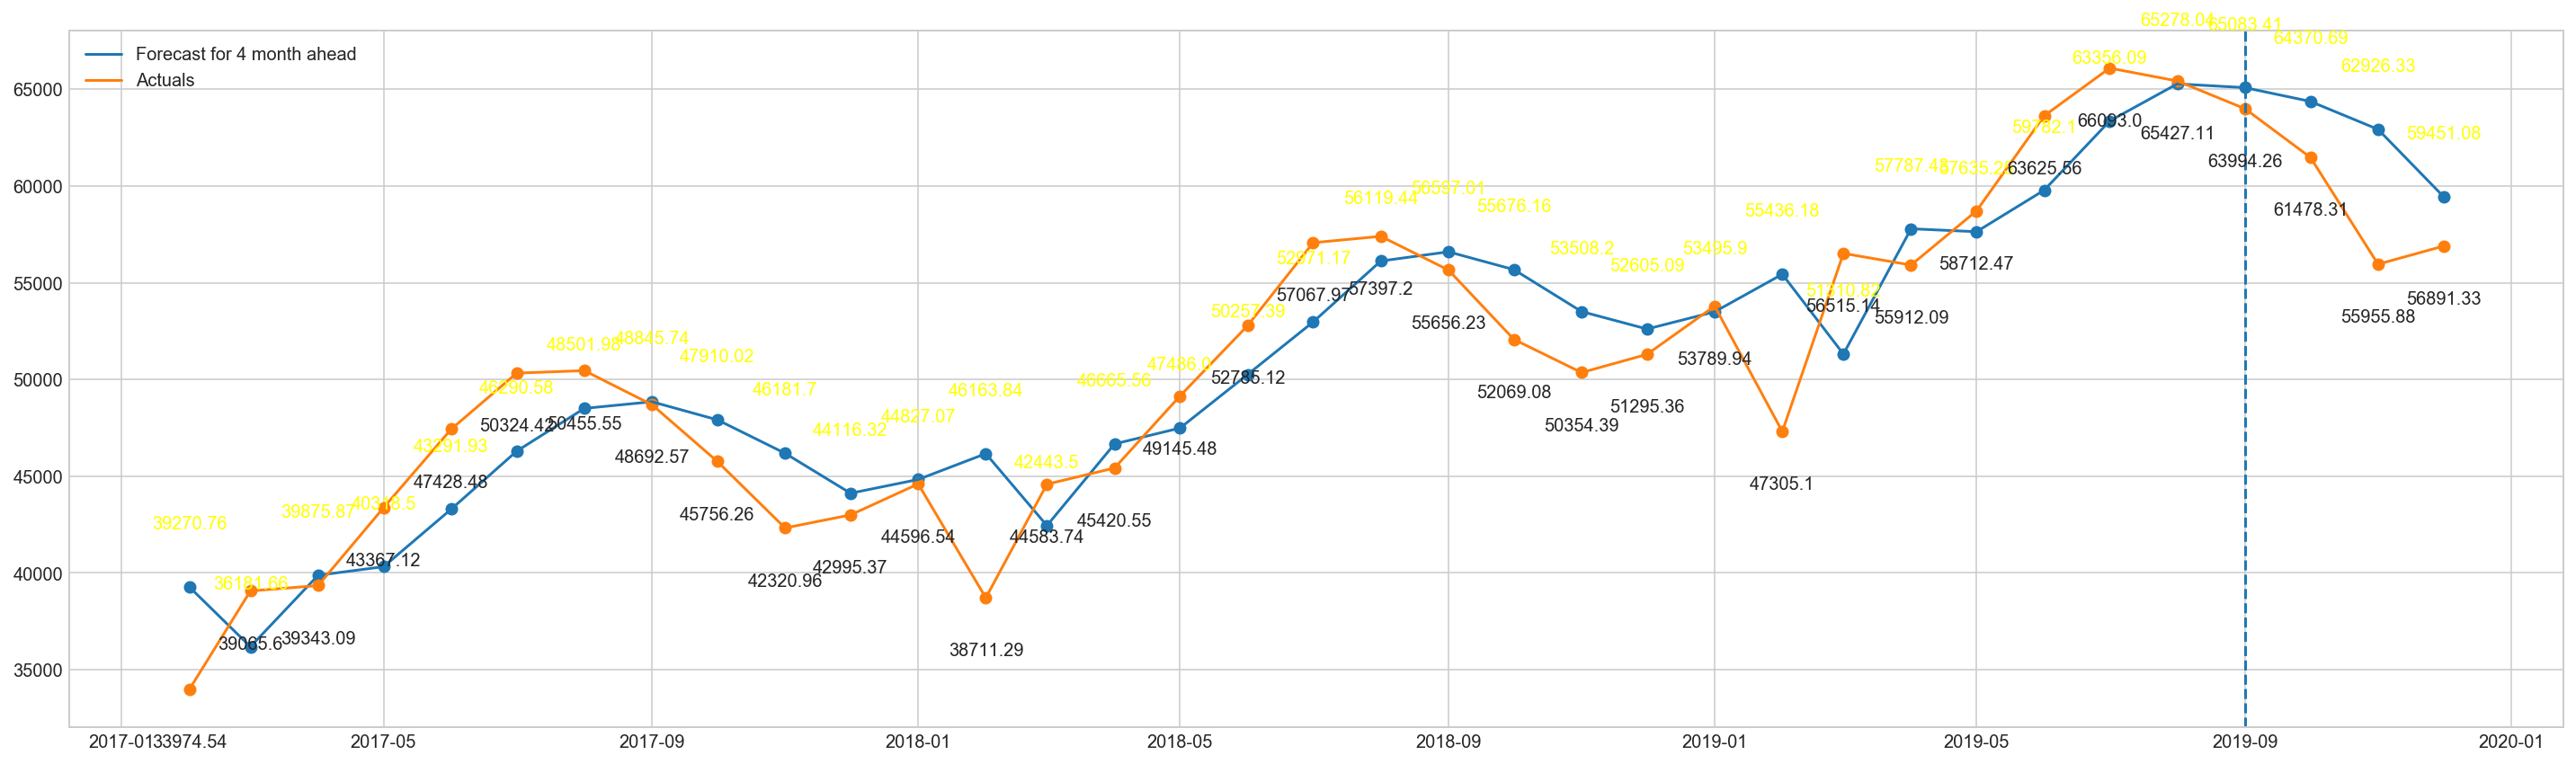

In [87]:
# Line Regression model
model = LinearRegression()
model.fit(x_train, y_train)
forecast = np.round(model.predict(pd.concat([x_train, x_test])),2)

fig, ax = plt.subplots(1, figsize=(20, 6))
ax.plot(df.index, forecast, label=f'Forecast for {NUM_M} month ahead')
ax.plot(df.index, df['Signal'], label='Actuals')
ax.axvline(x=df.index[int(len(x_train))], linestyle='--')
ax.legend()
plt.scatter(df.index, forecast)
plt.scatter(df.index, df['Signal'])

for i_x, i_y in zip(df.index, forecast):
    plt.text(i_x, i_y + 3000, f'{i_y}', ha='center', color='yellow')

for i_x, i_y in zip(df.index, df['Signal']):
    plt.text(i_x, i_y - 3000, f'{i_y}', ha='center')

plt.show()

In [60]:
# последовательное предсказание {NUM_M} будущих месяцев
df_under_2020_without_Signal = df_under_2020[['Time', 'Lag_1']].dropna()
to_pred_df = df_under_2020_without_Signal.iloc[-1:,:].copy()
time_last = df_under_2020.iloc[-1:,:]['Time'].values.copy()

preds = []
index = to_pred_df.index
for i in range(10):
    time_last += 1
    index += pd.offsets.MonthBegin(1)
    next_pred = pd.Series(
        model.predict(to_pred_df),
        index=index
    )

    to_pred_df = pd.DataFrame({
        'Time': time_last,
        'Signal': next_pred
    })

    preds.append(to_pred_df)

preds = pd.concat(preds)
preds['Signal'] = np.round(preds['Signal'], 2)

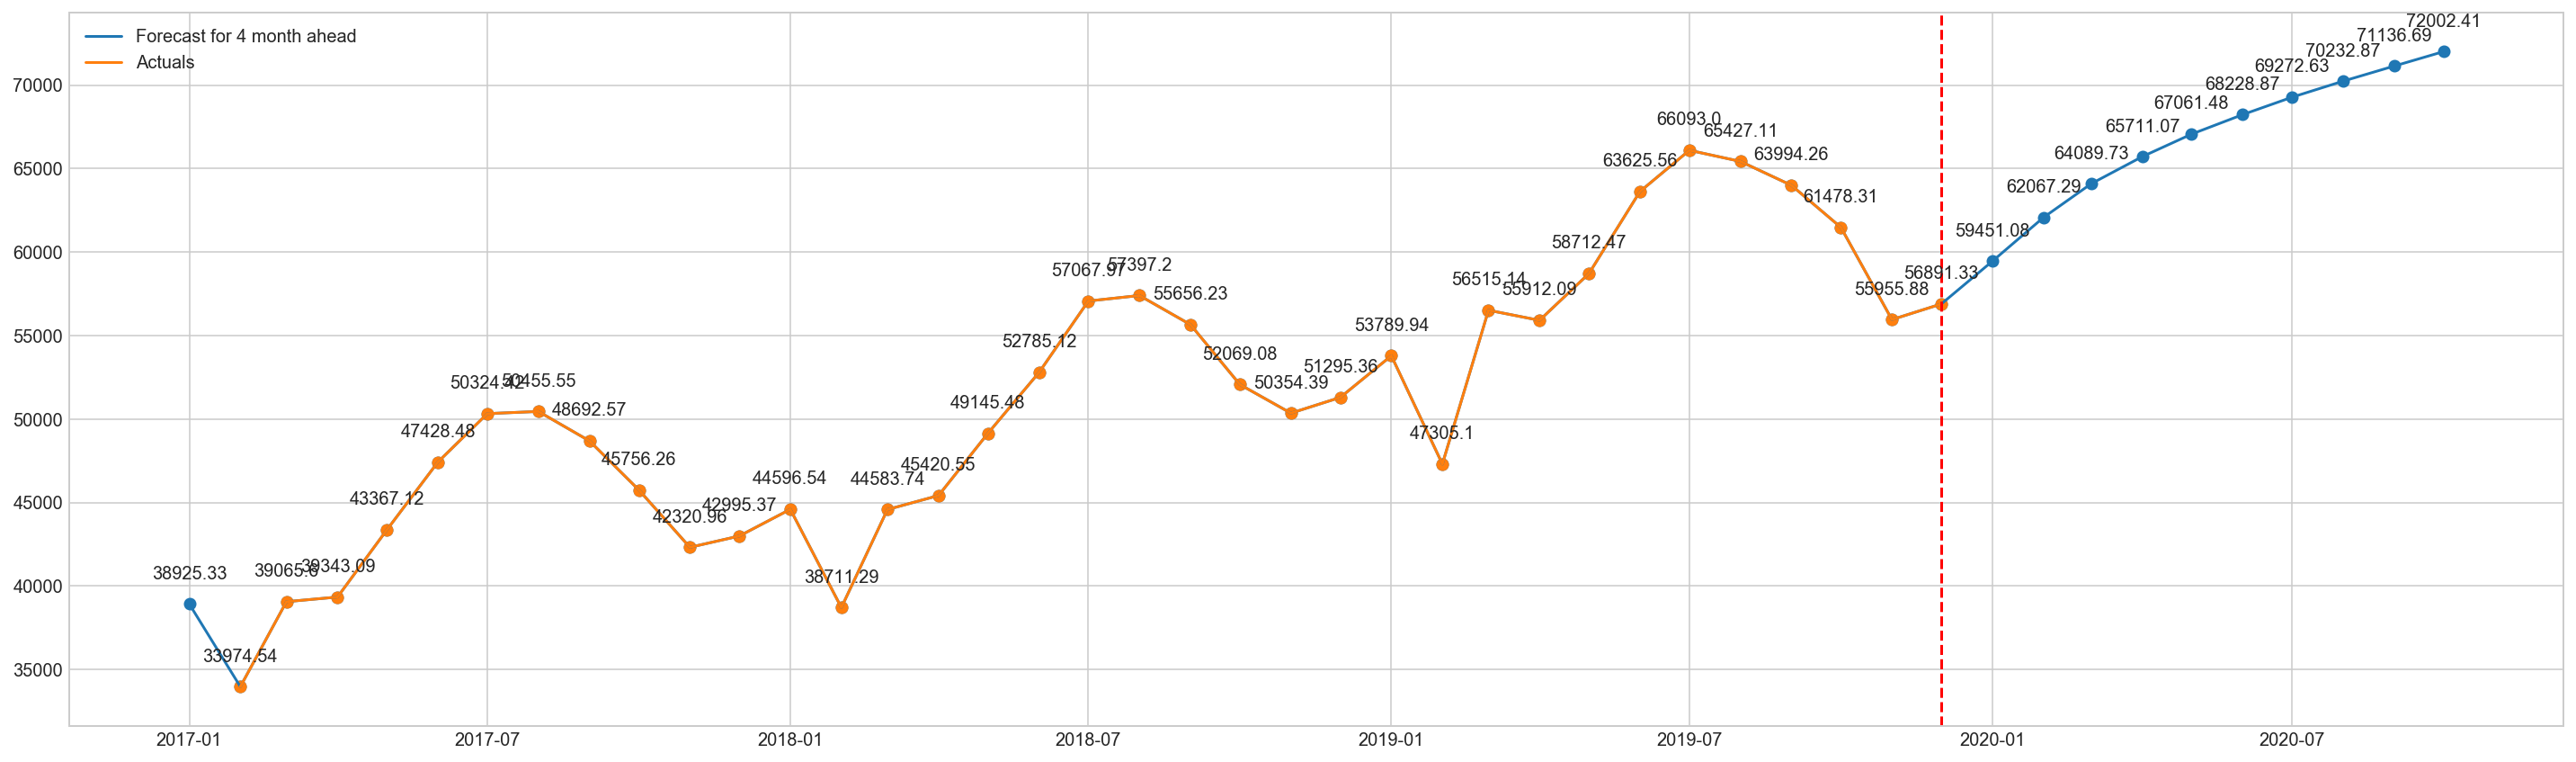

In [72]:
df_new = pd.concat([df_under_2020['Signal'], preds['Signal']])

fig, ax = plt.subplots(1, figsize=(20, 6))
ax.plot(df_new.index, df_new, label=f'Forecast for {NUM_M} month ahead')
ax.plot(df.index, df['Signal'], label='Actuals')
ax.axvline(x=df_new.index[int(len(df_under_2020['Signal']) - 1)], linestyle='--', color='red')
ax.legend()
plt.scatter(df_new.index, df_new)
plt.scatter(df.index, df['Signal'])

for i_x, i_y in zip(df_new.index, df_new):
    plt.text(i_x, i_y + 1500, f'{i_y}', ha='center')

plt.show()